In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

## Part 1 : Reading Data

In [216]:
data = pd.read_csv('data_new.csv')

In [217]:
data.columns

Index(['campaign_id', 'campaign_announcement_date', 'campaign_title',
       'campaign_objective_primary', 'value_demand', 'governance_demand',
       'activist_campaign_tactic', 'total_number_of_board_seats',
       'number_of_board_seats_sought', 'short_or_majority_or_full_slate',
       ...
       'pre_18m_residual_return', 'post_6m_residual_return',
       'post_12m_residual_return', 'post_18m_residual_return',
       'cumulative_6m_residual_return', 'cumulative_12m_residual_return',
       'cumulative_18m_residual_return', 'post_6m_total_return_bin',
       'post_12m_total_return_bin', 'post_18m_total_return_bin'],
      dtype='object', length=119)

In [218]:
len(data.columns)

119

## Part 2 : Data Cleaning

In [219]:
for i in data.columns[-7:]:
    data[i] = data[i].apply(lambda x : 100 * x)

In [220]:
X_Variables = ['price_at_announcement', 'ltm_eps_at_announcement', 
                    'earnings_yield_at_announcement', 'pre_18m_stock_price', 
                    'pre_12m_stock_price', 'pre_6m_stock_price','pre_3m_stock_price',
                    'pre_18m_price_to_earnings', 'pre_12m_price_to_earnings', 'pre_6m_price_to_earnings',
                    'pre_3m_price_to_earnings', 'pre_18m_dividends', 'pre_12m_dividends', 'pre_6m_dividends',
                    'pre_3m_dividends', 'pre_18m_total_return', 'pre_12m_total_return',
                    'pre_6m_total_return', 'pre_3m_total_return', 'sector',
                    'pre_6m_residual_return', 'pre_12m_residual_return', 'pre_18m_residual_return']
Categorical_Variables = ['sector']
Continuous_Variables = [i for i in X_Variables if i not in Categorical_Variables]

In [221]:
Categorical_Variables
Continuous_Variables

['price_at_announcement',
 'ltm_eps_at_announcement',
 'earnings_yield_at_announcement',
 'pre_18m_stock_price',
 'pre_12m_stock_price',
 'pre_6m_stock_price',
 'pre_3m_stock_price',
 'pre_18m_price_to_earnings',
 'pre_12m_price_to_earnings',
 'pre_6m_price_to_earnings',
 'pre_3m_price_to_earnings',
 'pre_18m_dividends',
 'pre_12m_dividends',
 'pre_6m_dividends',
 'pre_3m_dividends',
 'pre_18m_total_return',
 'pre_12m_total_return',
 'pre_6m_total_return',
 'pre_3m_total_return',
 'pre_6m_residual_return',
 'pre_12m_residual_return',
 'pre_18m_residual_return']

In [222]:
y_Varaibles = ["governance_demand"]
type(y_Varaibles)

list

In [223]:
governance_demand = ['Board Seats (activist group)','Other Governance Enhancements','Compensation Related Enhancements',
                    "Remove Director(s)","Social/Environmental/Political Issues","Remove Takeover Defenses","Add Independent Directors",
                     "Remove Officer(s)"
                    ]
governance_demand

['Board Seats (activist group)',
 'Other Governance Enhancements',
 'Compensation Related Enhancements',
 'Remove Director(s)',
 'Social/Environmental/Political Issues',
 'Remove Takeover Defenses',
 'Add Independent Directors',
 'Remove Officer(s)']

In [224]:
data.governance_demand = data.governance_demand.apply(lambda x : x if x in governance_demand else 'others')

In [225]:
data.governance_demand.value_counts() / len(data)

others                                   0.514471
Board Seats (activist group)             0.187128
Other Governance Enhancements            0.085049
Compensation Related Enhancements        0.069167
Remove Director(s)                       0.039599
Social/Environmental/Political Issues    0.037196
Remove Takeover Defenses                 0.031031
Add Independent Directors                0.028315
Remove Officer(s)                        0.008045
Name: governance_demand, dtype: float64

In [284]:
gover_demand_dict = {
    "Remove Officer(s)" : "Officer_demand",
    "Add Independent Directors" : "Officer_demand",
    "Remove Director(s)" : "Officer_demand",
    "Other Governance Enhancements" : "operations",
    "Compensation Related Enhancements" : "operations",
    'Social/Environmental/Political Issues': "operations",
    "Remove Takeover Defenses" : "operations",
    'Board Seats (activist group)' : "Board",
    "others" : "others"
}

In [285]:
data["governance_demand_group"] = data.governance_demand.apply(lambda x : gover_demand_dict[x])

In [286]:
data.governance_demand_group.value_counts()/len(data)

others            0.514471
operations        0.222443
Board             0.187128
Officer_demand    0.075959
Name: governance_demand_group, dtype: float64

In [287]:
data2 = data[data['governance_demand_group'] != 'others']

In [288]:
process_not_scale = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='median')), 
     Continuous_Variables),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')), 
     Categorical_Variables))

In [289]:
process_scale = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='median'),StandardScaler()), 
     Continuous_Variables),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')), 
     Categorical_Variables))

In [290]:
data1 = data[data['governance_demand'] != 'others']

In [291]:
X = data.drop(columns=['governance_demand'])
y = data['governance_demand']

X1 = data1.drop(columns=['governance_demand'])
y1 = data1['governance_demand']

X2 = data2.drop(columns=['governance_demand_group'])
y2 = data2['governance_demand_group']

In [292]:
ys = pd.DataFrame(y,columns=['governance_demand'])
ys1 = pd.DataFrame(y1,columns=['governance_demand'])
ys2 = pd.DataFrame(y2,columns=['governance_demand_group'])

In [293]:
X_train, X_test, y_train, y_test = train_test_split(X, ys, random_state=0, test_size=0.2)
#y_train.value_counts()

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, ys1, random_state=0, test_size=0.2)
#y_train.value_counts()

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, ys2, random_state=0, test_size=0.2)

## Part 3 : Model Part

### Logistic Regression

In [236]:
def produce_confusion_matrix(x_test,y_test,model):
    pred = model.predict(x_test)
    matrix = confusion_matrix(y_test, pred, labels=y_test['governance_demand'].unique())
    precision = [matrix[i,i] / sum(matrix[:,i]) for i in range(matrix.shape[1])]
    recall = [matrix[i,i] / sum(matrix[i,:]) for i in range(matrix.shape[1])]
    d1 = pd.DataFrame(precision, columns=['Precision'], index = y_test['governance_demand'].unique())
    d2 = pd.DataFrame(recall, columns=['Recall'], index = y_test['governance_demand'].unique())
    precision_recall = pd.concat([d1,d2], axis=1)
    return matrix, precision_recall

In [243]:
## Logistic Regression
# pipeline_lr = make_pipeline(process_scale, LogisticRegression(
#     max_iter=10000, verbose=0, multi_class='multinomial', solver='newton-cg'))
# ## Grid Search
# param_grid_lr = {'logisticregression__C': np.logspace(-3, 3, 7)}
# grid_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='accuracy')
# #X_train
# #y_train
# grid_lr.fit(X_train, y_train.values.reshape(-1,))

In [244]:
#grid.score(X_test, y_test)
# print("The best parameter for Logistic is {}".format(grid_lr.best_params_))
# print("Training accuracy for Logistic Regression is {}".format(round(grid_lr.score(X_train, y_train),5)))
# print("Testing accuracy for Logistic Regression is {}".format(round(grid_lr.score(X_test, y_test),5)))

In [245]:
# index = y_test['governance_demand'].unique()

In [246]:
# conf, pre_recall = produce_confusion_matrix(X_test, y_test, grid_lr) 
# conf

In [247]:
# pre_recall

### Eight types classfier (lg)

In [242]:
grid_lr.fit(X_train1, y_train1.values.reshape(-1,))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
  

In [98]:
#grid.score(X_test, y_test)
print("The best parameter for Logistic is {}".format(grid_lr.best_params_))
print("Training accuracy for Logistic Regression is {}".format(round(grid_lr.score(X_train1, y_train1),5)))
print("Testing accuracy for Logistic Regression is {}".format(round(grid_lr.score(X_test1, y_test1),5)))

The best parameter for Logistic is {'logisticregression__C': 100.0}
Training accuracy for Logistic Regression is 0.41055
Testing accuracy for Logistic Regression is 0.4129


In [99]:
conf, pre_recall = produce_confusion_matrix(X_test, y_test, grid_lr) 
conf

array([[305,   0,   0,   1,  18,   0,   3,   0,  11],
       [909,   0,   0,   7,  34,   0,  11,   4,  35],
       [ 15,   0,   0,   0,   0,   0,   0,   0,   0],
       [129,   0,   0,   0,   6,   0,   0,   0,   7],
       [ 42,   0,   0,   1,  30,   0,   1,   0,   0],
       [ 46,   0,   0,   0,   2,   1,   0,   0,   2],
       [138,   0,   0,   0,   9,   0,   7,   0,   4],
       [ 56,   0,   0,   0,   0,   0,   1,   1,   3],
       [ 47,   0,   0,   0,   3,   0,   1,   0,  25]])

In [100]:
pre_recall

,Precision,Recall
Board Seats (activist group),0.180794,0.902367
others,NaN,0.000000
Remove Officer(s),NaN,0.000000
Compensation Related Enhancements,0.000000,0.000000
Social/Environmental/Political Issues,0.294118,0.405405
Add Independent Directors,1.000000,0.019608
Other Governance Enhancements,0.291667,0.044304
Remove Takeover Defenses,0.200000,0.016393
Remove Director(s),0.287356,0.328947


### Three types classfier (lg)

In [249]:
pipeline_lr = make_pipeline(process_scale, LogisticRegression(
    max_iter=10000, verbose=0, multi_class='multinomial', solver='newton-cg'))
## Grid Search
param_grid_lr = {'logisticregression__C': np.logspace(-3, 3, 7)}
grid_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='accuracy')
#X_train
#y_train
grid_lr.fit(X_train2, y_train2.values.reshape(-1,))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
  

In [250]:
print("The best parameter for Logistic is {}".format(grid_lr.best_params_))
print("Training accuracy for Logistic Regression is {}".format(round(grid_lr.score(X_train2, y_train2),5)))
print("Testing accuracy for Logistic Regression is {}".format(round(grid_lr.score(X_test2, y_test2),5)))

The best parameter for Logistic is {'logisticregression__C': 0.1}
Training accuracy for Logistic Regression is 0.50256
Testing accuracy for Logistic Regression is 0.49892


In [251]:
def produce_confusion_matrix(x_test,y_test,model):
    pred = model.predict(x_test)
    matrix = confusion_matrix(y_test, pred, labels=y_test['governance_demand_group'].unique())
    precision = [matrix[i,i] / sum(matrix[:,i]) for i in range(matrix.shape[1])]
    recall = [matrix[i,i] / sum(matrix[i,:]) for i in range(matrix.shape[1])]
    d1 = pd.DataFrame(precision, columns=['Precision'], index = y_test['governance_demand_group'].unique())
    d2 = pd.DataFrame(recall, columns=['Recall'], index = y_test['governance_demand_group'].unique())
    precision_recall = pd.concat([d1,d2], axis=1)
    return matrix, precision_recall

In [253]:
conf, pre_recall = produce_confusion_matrix(X_test2, y_test2, grid_lr) 
conf

array([[120, 232,   4],
       [ 99, 330,  10],
       [ 36,  85,  14]])

In [254]:
pre_recall

,Precision,Recall
Board,0.470588,0.337079
operations,0.510046,0.751708
Officer_demand,0.500000,0.103704


### TreeModel (random forest and XGboost)

In [255]:
# ## Random Forest
# pipeline_rf = make_pipeline(process_not_scale, 
#                             RandomForestClassifier(random_state = 1))
# ## Grid Search
# param_grid_rf = {'randomforestclassifier__n_estimators': [100, 300],
#                 'randomforestclassifier__max_features': ['auto', 'sqrt']}
# grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='accuracy')

In [256]:
# grid_rf.fit(X_train, y_train.values.reshape(-1,))

In [257]:
# print("The best parameter for Logistic is {}".format(grid_rf.best_params_))
# print("Training accuracy for Random Forest is {}".format(round(grid_rf.score(X_train, y_train),5)))
# print("Testing accuracy for Random Forest is {}".format(round(grid_rf.score(X_test, y_test),5)))

### Eight Type classfiers(rf)

In [258]:
grid_rf.fit(X_train1, y_train1.values.reshape(-1,))

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
  

In [259]:
print("The best parameter for Logistic is {}".format(grid_rf.best_params_))
print("Training accuracy for Random Forest is {}".format(round(grid_rf.score(X_train1, y_train1),5)))
print("Testing accuracy for Random Forest is {}".format(round(grid_rf.score(X_test1, y_test1),5)))

The best parameter for Logistic is {'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__n_estimators': 300}
Training accuracy for Random Forest is 0.98171
Testing accuracy for Random Forest is 0.44301


In [260]:
## Random Forest
pipeline_rf = make_pipeline(process_not_scale, 
                            RandomForestClassifier(random_state = 1))
## Grid Search
param_grid_rf = {'randomforestclassifier__n_estimators': [100, 300],
                'randomforestclassifier__max_features': ['auto', 'sqrt']}
grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='accuracy')

### Three Type classfiers (rf)

In [261]:
grid_rf.fit(X_train2, y_train2.values.reshape(-1,))

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
  

In [262]:
print("The best parameter for Logistic is {}".format(grid_rf.best_params_))
print("Training accuracy for Random Forest is {}".format(round(grid_rf.score(X_train2, y_train2),5)))
print("Testing accuracy for Random Forest is {}".format(round(grid_rf.score(X_test2, y_test2),5)))

The best parameter for Logistic is {'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__n_estimators': 300}
Training accuracy for Random Forest is 0.98601
Testing accuracy for Random Forest is 0.56774


In [266]:
def produce_confusion_matrix(x_test,y_test,model):
    pred = model.predict(x_test)
    matrix = confusion_matrix(y_test, pred, labels=y_test['governance_demand_group'].unique())
    precision = [matrix[i,i] / sum(matrix[:,i]) for i in range(matrix.shape[1])]
    recall = [matrix[i,i] / sum(matrix[i,:]) for i in range(matrix.shape[1])]
    d1 = pd.DataFrame(precision, columns=['Precision'], index = y_test['governance_demand_group'].unique())
    d2 = pd.DataFrame(recall, columns=['Recall'], index = y_test['governance_demand_group'].unique())
    precision_recall = pd.concat([d1,d2], axis=1)
    return matrix, precision_recall

In [267]:
conf, pre_recall = produce_confusion_matrix(X_test2, y_test2, grid_rf) 
conf

array([[191, 154,  11],
       [126, 292,  21],
       [ 56,  34,  45]])

In [268]:
pre_recall

,Precision,Recall
Board,0.512064,0.536517
operations,0.608333,0.665148
Officer_demand,0.584416,0.333333


### Feature importance (rf)

In [269]:
rf = RandomForestClassifier(n_estimators = 300,random_state = 1)
grid_rf.fit(X_train2, y_train2.values.reshape(-1,))

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
  

In [270]:
importance = grid_rf.best_estimator_.get_params()["randomforestclassifier"].feature_importances_

In [271]:
importance

array([0.05251435, 0.05587602, 0.04559018, 0.05499808, 0.05531061,
       0.05571778, 0.05660327, 0.04219509, 0.04107757, 0.04220515,
       0.04301558, 0.02203352, 0.01968231, 0.01997656, 0.02136076,
       0.04382967, 0.04374478, 0.04421437, 0.04836725, 0.04135451,
       0.04008501, 0.03959034, 0.00426423, 0.00166008, 0.0027195 ,
       0.00322031, 0.00470941, 0.002304  , 0.00506705, 0.0053497 ,
       0.00554294, 0.00164001, 0.00473427, 0.00294958, 0.00398402,
       0.00338122, 0.00329441, 0.00373433, 0.00354551, 0.00465545,
       0.00189641, 0.00200484])

In [272]:
Continuous_Variables = np.array(Continuous_Variables)

In [273]:
importance.sort()
importance[::-1]

array([0.05660327, 0.05587602, 0.05571778, 0.05531061, 0.05499808,
       0.05251435, 0.04836725, 0.04559018, 0.04421437, 0.04382967,
       0.04374478, 0.04301558, 0.04220515, 0.04219509, 0.04135451,
       0.04107757, 0.04008501, 0.03959034, 0.02203352, 0.02136076,
       0.01997656, 0.01968231, 0.00554294, 0.0053497 , 0.00506705,
       0.00473427, 0.00470941, 0.00465545, 0.00426423, 0.00398402,
       0.00373433, 0.00354551, 0.00338122, 0.00329441, 0.00322031,
       0.00294958, 0.0027195 , 0.002304  , 0.00200484, 0.00189641,
       0.00166008, 0.00164001])

In [275]:
#Continuous_Variables[importance.argsort()[::-1][:10]]

In [276]:
name = ['pre_3m_stock_price', 'ltm_eps_at_announcement',
       'pre_6m_stock_price', 'pre_12m_stock_price', 'pre_18m_stock_price',
       'price_at_announcement', 'pre_3m_total_return',
       'earnings_yield_at_announcement', 'pre_6m_total_return',
       'pre_18m_total_return']

In [277]:
value = [0.05660327, 0.05587602, 0.05571778, 0.05531061, 0.05499808,
       0.05251435, 0.04836725, 0.04559018, 0.04421437, 0.04382967]

In [278]:
d = {'name': name, 'value': value}

In [279]:
df = pd.DataFrame(data=d)

In [280]:
#df

Text(0.5, 1.0, 'Top 10 important features for Governance Demand')

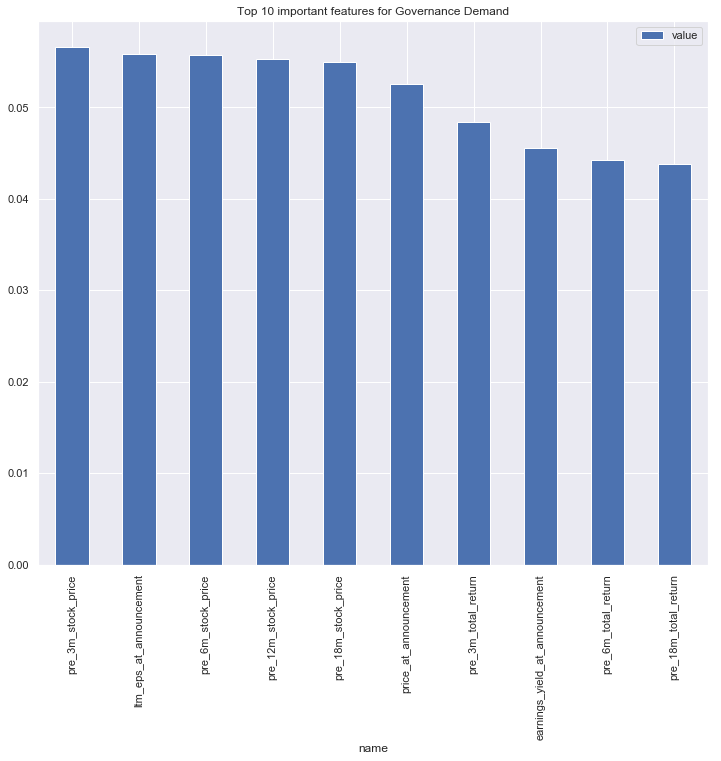

In [281]:
import seaborn as sns
sns.set()
sns.set(rc={'figure.figsize':(12,10)})
#ax = plt.gca()
ax = df.plot.bar(x='name', y='value')
plt.title('Top 10 important features for Governance Demand')

### SVM

In [307]:
from sklearn import svm
svc = svm.SVC(kernel='rbf')
svc.fit(X_train2,y_train2)
conf, pre_recall = produce_confusion_matrix(X_test2, y_test2, svc) 
conf

array([[108, 240,   8],
       [ 69, 353,  17],
       [ 24,  61,  50]])

In [308]:
pre_recall

,Precision,Recall
Board,0.537313,0.303371
operations,0.539755,0.804100
Officer_demand,0.666667,0.370370


### Nearest 

In [310]:
from sklearn.neighbors import NearestCentroid

In [313]:
nc = NearestCentroid()
param_grid = {'metric':['euclidean','manhattan']}
grid = GridSearchCV(nc, param_grid, cv=5)
grid.fit(X_train2, y_train2)
print("The best parameter for NearestCentroid is {}".format(grid.best_params_))
print("Training accuracy for NearestCentroid is {}".format(round(grid.score(X_train2, y_train2),5)))
print("Testing accuracy for NearestCentroid is {}".format(round(grid.score(X_test2, y_test2),5)))

The best parameter for NearestCentroid is {'metric': 'manhattan'}
Training accuracy for NearestCentroid is 0.43906
Testing accuracy for NearestCentroid is 0.46882


In [315]:
conf, pre_recall = produce_confusion_matrix(X_test2, y_test2, grid) 
conf

array([[ 91, 130, 135],
       [ 61, 258, 120],
       [ 21,  27,  87]])

In [316]:
pre_recall

,Precision,Recall
Board,0.526012,0.255618
operations,0.621687,0.587699
Officer_demand,0.254386,0.644444


### Ensemble Model

In [323]:
import warnings
warnings.filterwarnings("ignore")
X = data2.drop(columns=['governance_demand_group'])
y = data2['governance_demand_group']
X = process_not_scale.fit(X,y).transform(X)
y = pd.DataFrame(y,columns=['governance_demand_group'])
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state=0, test_size=0.2)
eclf2 = VotingClassifier(estimators=[('lg', LogisticRegression(C = 0.1)), 
                                     ('rf', RandomForestClassifier(n_estimators = 300)),
                                    ('nc', NearestCentroid(metric =  'manhattan')),
                                    ('svc', svm.SVC(kernel='rbf'))], 
                         voting='hard')
eclf2 = eclf2.fit(X_train2, y_train2)
y_pred2 = eclf2.predict(X_test2)
print("Accuracy is %.2f%%" % ((np.sum(y_pred2 == np.array(y_test2).flatten()) / len(y_pred2))*100))

Accuracy is 55.38%


In [324]:
def produce_confusion_matrix(x_test,y_test,model):
    pred = model.predict(x_test)
    matrix = confusion_matrix(y_test, pred, labels=y_test['governance_demand_group'].unique())
    precision = [matrix[i,i] / sum(matrix[:,i]) for i in range(matrix.shape[1])]
    recall = [matrix[i,i] / sum(matrix[i,:]) for i in range(matrix.shape[1])]
    d1 = pd.DataFrame(precision, columns=['Precision'], index = y_test['governance_demand_group'].unique())
    d2 = pd.DataFrame(recall, columns=['Recall'], index = y_test['governance_demand_group'].unique())
    precision_recall = pd.concat([d1,d2], axis=1)
    return matrix, precision_recall

In [325]:
conf, pre_recall = produce_confusion_matrix(X_test2, y_test2, eclf2) 
conf

array([[153, 176,  27],
       [102, 304,  33],
       [ 38,  39,  58]])

In [326]:
pre_recall

,Precision,Recall
Board,0.522184,0.429775
operations,0.585742,0.692483
Officer_demand,0.491525,0.429630
